<h2 style="color:orange;font-weight:bold;font-family:arial">Speech Emotion Recognition System</h2>
<h3 style="color:blue;font-weight:bold;font-family:arial">Group 1</h3>

##### Samruddhi Khairnar - kbtug20170@kbtcoe.org 
##### Avichal Sharma - avichalsharma2003@gmail.com
##### Yash Rokade - rokadeyash34@gmail.com
##### Araya Gupta - arayagupta28@gmail.com
##### Priyanshu Bisht - bisht.priyanshu05@gmail.com

##### **CREMA-D** Dataset : (! git clone https://github.com/CheyneyComputerScience/CREMA-D.git)
##### **Emotions** : Anger (ANG),  Disgust (DIS),  Fear (FEA),  Happy/Joy (HAP),  Neutral (NEU),  Sad (SAD).
##### **Emotion Levels** : Low (LO),  Medium (MD),  High (HI),  Unspecified (XX).
##### **Naming of files** : Actor id_Sentence_Emotion_Level.wav

#### **Imports** :

In [ ]:
# ! pip3 install librosa mir_eval

In [15]:
import matplotlib.pyplot as plt
import librosa
import librosa.util, librosa.display
import numpy as np
import mir_eval
import scipy
import seaborn as sns
from IPython.display import Audio

#### **Loading sample files from the dataset** :

In [16]:
y1, sr1 = librosa.load('./AudioWAV/1001_DFA_ANG_XX.wav')
y2, sr2 = librosa.load('./AudioWAV/1001_DFA_DIS_XX.wav')
y3, sr3 = librosa.load('./AudioWAV/1001_DFA_FEA_XX.wav')
y4, sr4 = librosa.load('./AudioWAV/1001_DFA_HAP_XX.wav')
y5, sr5 = librosa.load('./AudioWAV/1001_DFA_NEU_XX.wav')
y6, sr6 = librosa.load('./AudioWAV/1001_DFA_SAD_XX.wav')

In [17]:
Audio(data=y5, rate=sr5) # Neutral

In [18]:
Audio(data=y1, rate=sr1) # Angry

#### **Visualizing one audio file for each emotion** :

In [19]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy/Joy', 'Neutral', 'Sad']

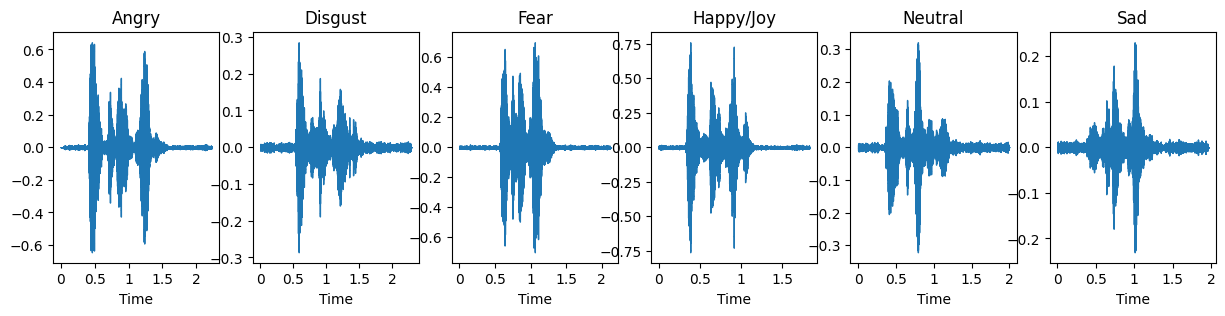

In [20]:
fig, axes = plt.subplots(1,6, figsize=(15,3))
for i in range(1,7):
    librosa.display.waveshow(locals()['y'+str(i)], sr=22500, ax=axes[i-1])
    axes[i-1].set_title(emotions[i-1]);

#### **Plotting frequency domain spectrograms** :

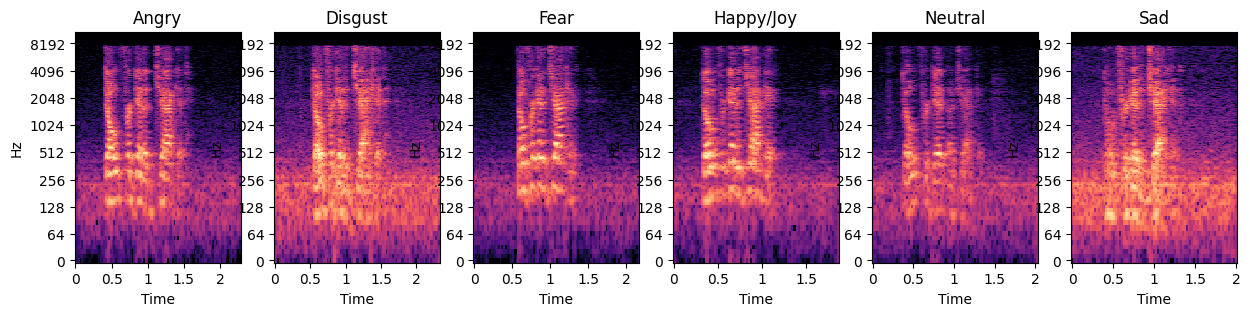

In [21]:
fig, axes = plt.subplots(1,6, figsize=(15,3))

for i in range(1,7):
    y = locals()['y'+str(i)]
    
    # Short-time Fourier transform (STFT) = gives Frequency domain series - freq vs time - spectrogram.
    y_stft = np.abs(librosa.stft(y))
    y_stft = librosa.amplitude_to_db(y_stft, ref=np.max) # Convert Hz to DB scale.

    librosa.display.specshow(y_stft, x_axis='time', y_axis='log', ax=axes[i-1])
    axes[i-1].set_title(emotions[i-1]);

#### **Plotting Mel Spectrograms** :

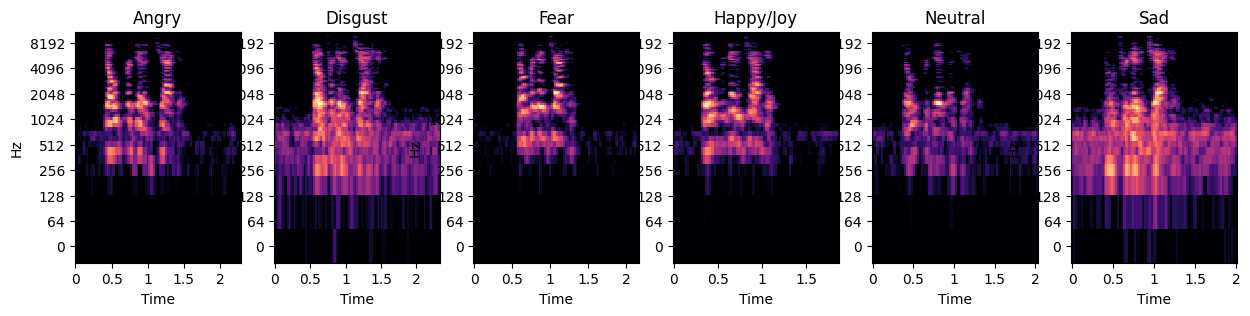

In [22]:
fig, axes = plt.subplots(1,6, figsize=(15,3))

for i in range(1,7):
    y = locals()['y'+str(i)]
    
    # Mel Spectrogram = converts frequencies to mel scale, interpretable by humans.
    y_mel = librosa.feature.melspectrogram(y=y, sr=22500)
    y_mel_db = librosa.amplitude_to_db(y_mel, ref=np.max) # Mel Scale to DB.
    
    librosa.display.specshow(y_mel_db, x_axis='time', y_axis='log', ax=axes[i-1]);
    axes[i-1].set_title(emotions[i-1]);

#### **Creation of empty dataframe to store audio features** :

In [23]:
cols = np.hstack((['actor','sentence', 'emotion','level'],['mfcc'+str(i) for i in range(20)], 'y_harmonic', 'y_percussive', ['C'+str(i) for i in range(84)], ['chroma'+str(i)+"a" for i in range(12)], ['chroma'+str(i)+"b" for i in range(12)], 'onsets', 'tempo', 'beats', ['c_sync'+str(i)+"a" for i in range(12)], ['c_sync'+str(i)+"b" for i in range(12)], 'spectral_bandwidth', 'spectral_rolloff', 'spectral_centroids'))

In [24]:
import pandas as pd
import cmath
df = pd.DataFrame(index=[i in range(7442)], columns = cols)

In [25]:
df.shape

(1, 164)

#### **In a loop, extracting features of all 7442 audio files** :
###### ( Each audio feature is explained below, using comments )

In [29]:
import os, glob
path = './AudioWAV'
for i,filename in enumerate(glob.glob(os.path.join(path, '*.wav'))):
  with open(os.path.join(os.getcwd(), filename), 'r') as f:
    actor, sentence, emotion, level = filename[11:len(filename)-4].split('_')

    y,_ = librosa.load(filename)
    sr = 22500
    # Trim = Remove leading and trailing silence.
    y,_ = librosa.effects.trim(y)

    # MFCC = compressible representations of the Log Mel Spectrogram. 
    MFCC = librosa.feature.mfcc(y=y, sr=sr)
    MFCC = [np.mean(x) for x in MFCC]

    # Harmonic = sound we perceive as melodies and chords.
    # Percussive = sound which is noise-like : eg=drums.
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    y_harmonic, y_percussive = y_harmonic.mean(), y_percussive.mean()

    # CQT = computes the constant-Q transform of an audio signal - Similar to Fourier Transform.
    C = librosa.cqt(y)
    C_mean = [np.mean(x) for x in C]
    C_mean = [complex(x).real for x in C_mean]

    # Chroma = quality of a specific tone, bins the audio into 12 tones/notes - CC#DD#EFF#GG#AA#B.
    chroma = librosa.feature.chroma_cqt(C=C, sr=sr)
    chroma_mean = [np.mean(x) for x in chroma]
    a, b = [],[]
    for j in range(len(chroma_mean)):
      polar = cmath.polar(complex(chroma_mean[j]))
      a.append(polar[0])
      b.append(polar[1])

    # Onset = the beginning of a musical note, where amplitude rises from zero to an initial peak = event.
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_envelope)
    onsets = onsets.shape[0]

    # Tempo = Speed of beats in bpm.
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_envelope)

    # Sync = temporal feature - shows repitition of structure.
    c_sync = librosa.util.sync(chroma, beats, aggregate=np.median)
    c_sync = [np.mean(x) for x in c_sync]
    c, d = [],[]
    for j in range(len(c_sync)):
      polar = cmath.polar(complex(c_sync[j]))
      c.append(polar[0])
      d.append(polar[1])

    # Spectral Bandwidth = difference between the upper and lower frequencies.
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth = spectral_bandwidth.mean()

    # Spectral Rolloff = frequency below which a specified percentage of the total spectral energy(e.g. 85 %) lies.
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    spectral_rolloff = spectral_rolloff.mean()

    # Spectral Centroids = indicates where the center of mass of the spectrum is.
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroids = spectral_centroids.mean()

    arr = np.hstack(([], actor, sentence, emotion, level, MFCC, y_harmonic, y_percussive, C_mean, a, b, onsets, tempo, beats.shape[0], c,d, spectral_bandwidth, spectral_rolloff, spectral_centroids))

    df.loc[i] = arr
    print(i, end='\r')

/tmp/ipykernel_73178/2108819731.py:66: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[i] = arr


/home/tweety/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tweety/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


#### **Data extracted from the audio files** :

In [30]:
df.tail()

,actor,sentence,emotion,level,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,c_sync5b,c_sync6b,c_sync7b,c_sync8b,c_sync9b,c_sync10b,c_sync11b,spectral_bandwidth,spectral_rolloff,spectral_centroids
7437,1088,IWL,ANG,XX,-334.07532,119.44679,14.646216,28.523333,-12.546865,11.73191,...,1.4783055022033194,0.0,1.4575023461064391,-1.3126725226898417,-1.0544115261911284,-1.383971628688754,0.5159982806594153,1768.2227007784973,2717.8485576923076,1344.599695772602
7438,1083,ITS,ANG,XX,-316.73865,101.76926,0.67381716,48.004242,-11.881831,22.851318,...,-0.03710678001038375,0.6458507824145409,-0.8606794380664625,-0.9672323969570018,0.38930280983169524,-0.11460376812022251,-0.17436002421654634,1925.7413702994431,3957.40573689089,2119.9508926134736
7439,1001,WSI,ANG,XX,-309.03857,120.553055,-16.670698,45.73387,-19.48923,15.248727,...,-0.8770000702607337,1.018961011070104,1.1673207111977795,1.5169841837473208,1.3753260049158527,0.7480333310154835,1.1432006359120506,1735.1481743803595,3580.8912374205506,1929.48917656306
7440,1006,IEO,SAD,MD,-456.80273,146.1894,16.46978,60.749313,-14.895783,35.10077,...,-1.2839610296906319,-1.4341073184958908,1.4571805902714137,1.5427844526936443,-0.46224781521041913,-1.3995935114361682,1.0582519595857662,1771.3584093472998,2468.9762766768295,1147.417731261329
7441,1035,DFA,ANG,XX,-300.88153,106.72035,-1.637705,45.125893,-1.550283,8.407706,...,-0.535327995111592,1.5062019012917098,0.0,1.1656411899655599,0.24151964044683624,0.31908204710414445,-1.5527784531608455,1837.7351426413513,3404.836554276316,1587.3659196671856


#### **Storing the extracted dataset as a CSV file** :

In [32]:
df.to_csv('crema.csv', index=False)